In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from imblearn.datasets import fetch_datasets
import matplotlib.pyplot as plt
from IPython.display import display
pd.set_option('max_rows', 5)
%matplotlib inline

/root/local/python-3.7.4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/root/local/python-3.7.4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)
/root/local/python-3.7.4/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.base module is  deprecated in versi

## 不均衡データ (imbalanced data)
---
クラス $A$ とクラス $B$ のサンプルサイズが $A:B=1:99$ など極端な偏りのあるデータ。 $A$ を無視して全て $B$ と予測するモデルでも正解率99%を達成してしまう。単純に正解率などをモデルの評価指標とできないので、他の指標が必要。

不均衡データを評価するには、まず混同行列を理解しないといけない。

## 混同行列 (confusion matrix)
---
予測と正解ラベルの関係をマトリクス図にしたもの。

- 関心のあるクラス (サンプル数の少ないほう) に分類したものが <span class="text-shadow" style="color: red;">陽性 (Positive)</span> 、関心のないクラス (サンプル数の多いほう) に分類したものが <span class="text-shadow" style="color: blue;">陰性 (Negative)</span>
- 分類が合っていれば <span class="text-shadow" style="color: green;">真 (True)</span> 、間違っていれば <span class="text-shadow" style="color: orange;">偽 (False)</span>

<table class="border text-center text-black background-white">
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th><span style="color: red;">True と予測</span></th>
        <th><span style="color: blue;">False と予測</span></th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが True<br />(関心のあるクラス)</th>
        <td><span style="color: green;">真</span><span style="color: red;">陽性</span><br /><span style="color: green;">True</span> <span style="color: red;">Positive</span></td>
        <td><span style="color: orange;">偽</span><span style="color: blue;">陰性</span><br><span style="color: orange;">False</span> <span style="color: blue;">Negative</span></td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td><span style="color: orange;">偽</span><span style="color: red;">陽性</span><br /><span style="color: orange;">False</span> <span style="color: red;">Positive</span></td>
        <td><span style="color: green;">真</span><span style="color: blue;">陰性</span><br /><span style="color: green;">True</span> <span style="color: blue;">Negative</span></td>
    </tr>
</table>

###### 練習問題

`mammography`データセットに任意の分類アルゴリズムを適用し、混同行列を作成する。

In [2]:
dataset = fetch_datasets(filter_data=['mammography'])['mammography']
mammography = pd.DataFrame(
    np.column_stack([dataset.data,
                     np.where(dataset.target == 1, 1, 0)]))
n_columns = mammography.columns.size
mammography.columns = [
    f'$x_{i+1}$' if i < n_columns - 1 else '$y$' for i in range(n_columns)
]
print('mammography')
display(mammography)

mammography


,$x_1$,$x_2$,$x_3$,$x_4$,$x_5$,$x_6$,$y$
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0.0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0.0
...,...,...,...,...,...,...,...
11181,0.736644,-0.222474,-0.050653,1.509665,0.539269,1.315229,1.0
11182,0.177003,-0.191508,-0.501468,1.578864,7.750705,1.555951,1.0


In [3]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression().fit(mammography.iloc[:, :-1].values,
                                 mammography.iloc[:, -1].values)
y_true = mammography.iloc[:, -1].values.astype(bool)
y_pred = model.predict(mammography.iloc[:, :-1].values).astype(bool)
trues = np.vstack([y_true, ~y_true]).astype(int)
preds = np.column_stack([y_pred, ~y_pred]).astype(int)
trues.dot(preds)

array([[  105,   155],
       [   27, 10896]])

### Pythonでの混同行列作成方法
---
`sklearn.metrics.confusion_matrix`を使用する。ヒートマップで表示するには`sklearn.metrics.plot_confusion_matrix`を使用する。

In [4]:
metrics.confusion_matrix??

In [5]:
x = mammography.iloc[:, :-1]
y = mammography.iloc[:, -1]
model = LogisticRegression().fit(x, y)
pred = model.predict(x)
metrics.confusion_matrix(y, pred)

array([[10896,    27],
       [  155,   105]])

In [6]:
metrics.plot_confusion_matrix??

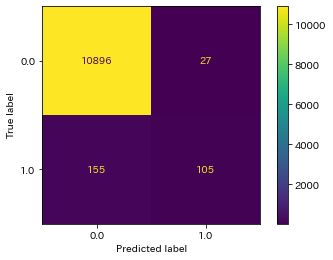

In [7]:
metrics.plot_confusion_matrix(model, x, y, values_format='d')
plt.show()

## 混同行列を利用した評価指標

### F1スコア
---
適合率と再現率を組み合わせた指標。

#### 適合率 (precision)
---
陽性 (関心あり) という予測の信頼度。陽性と判定する基準を厳しく (微妙なものは陰性に分類) すると向上。

<span class="text-shadow" style="color: lime;">PRE</span> = <span class="text-shadow" style="color: yellow;">True Positive</span> ÷ <span class="text-shadow" style="color: red;">Predicted True</span>

<table class="border text-center background-white">
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th><span style="color: red;">True と予測</span></th>
        <th class="text-black">False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-black">正解ラベルが True<br />(関心のあるクラス)</th>
        <td style="background-color: red;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td class="text-black">偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-black">正解ラベルが False<br />(関心のないクラス)</th>
        <td class="text-black" style="background-color: red;">偽陽性<br />False Positive</td>
        <td class="text-black">真陰性<br />True Negative</td>
    </tr>
</table>

###### 練習問題

`pred`データセットから適合率を算出する。

In [8]:
x = mammography.iloc[:, :-1].values
y = mammography.iloc[:, -1].values
model = LogisticRegression(random_state=1234).fit(x, y)
pred = pd.DataFrame({
    '正解':
    y.astype(int),
    '予測':
    model.predict(x).astype(int),
    '確率':
    model.predict_proba(x)[:, 1]
})
print('pred')
display(pred)

pred


,正解,予測,確率
0,0,0,0.000087
1,0,0,0.000190
...,...,...,...
11181,1,0,0.069676
11182,1,1,0.947977


In [9]:
true_positive = pred.query('正解 == 1 and 予測 == 1').index.size
predicted_true = pred.query('予測 == 1').index.size
pre = true_positive / predicted_true
print(f'適合率 : {pre:.3f}')

適合率 : 0.795


##### Pythonでの適合率算出方法
---
`sklearn.metrics.precision_score`を使用する。

In [10]:
metrics.precision_score??

In [11]:
metrics.precision_score(pred['正解'], pred['予測'])

0.7954545454545454

#### 再現率 (recall)
---
陽性 (関心がある) データの捕捉率。陽性と判定する基準を緩く (微妙なものは陽性に分類) すると向上。

<span class="text-shadow" style="color: magenta;">REC</span> = <span class="text-shadow" style="color: yellow;">True Positive</span> ÷ <span class="text-shadow" style="color: purple;">Labeled True</span>

<table class="border text-center text-black background-white">
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold"><span style="color: purple;">正解ラベルが True<br />(関心のあるクラス)</span></th>
        <td style="background-color: purple;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td style="background-color: purple;">偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td>偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
    </tr>
</table>

###### 練習問題

`pred`データセットから再現率を算出する。

In [12]:
true_positive = pred.query('正解 == 1 and 予測 == 1').index.size
labeled_true = pred.query('正解 == 1').index.size
rec = true_positive / labeled_true
print(f'再現率 : {rec:.3f}')

再現率 : 0.404


##### Pythonでの再現率算出方法
---
`sklearn.metrics.recall_score`を使用する。

In [13]:
metrics.recall_score??

In [14]:
metrics.recall_score(pred['正解'], pred['予測'])

0.40384615384615385

#### F1スコア
---
<span class="text-shadow" style="color: lime;">適合率 (Precision)</span>と<span class="text-shadow
" style="color: magenta;">再現率 (Recall)</span>の調和平均。

$
{\displaystyle F1=\frac
    {2\times PRE\times REC}
    {PRE+REC}}
$

<table class="border text-center text-black background-white">
    <tr class="border-none">
        <th colspan="3"><span style="color: lime;">適合率<br />Precision</span></th>
        <th></th>
        <th colspan="3"><span style="color: magenta;">再現率<br />Recall</span></th>
    </tr>
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th><span style="color: red;">True と予測</span></th>
        <th>False と予測</th>
        <th class="border-none"></th>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが True<br />(関心のあるクラス)</th>
        <td style="background-color: red;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td>偽陰性<br />False Negative</td>
        <td class="border-none"></td>
        <th class="border-bottom border-right-bold"><span style="color: purple;">正解ラベルが True<br />(関心のあるクラス)</span></th>
        <td style="background-color: purple;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td style="background-color: purple;">偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td style="background-color: red;">偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
        <td class="border-none"></td>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td>偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
    </tr>
</table>

<span class="text-shadow" style="color: lime;">適合率</span>と<span class="text-shadow" style="color: magenta;">再現率</span>の両方が高くないとF1スコアも高くならない

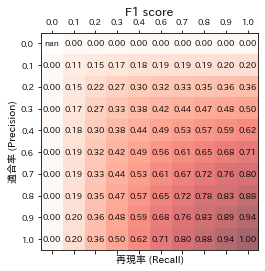

In [15]:
from helpers.imbalanced_data import f1_matrix
f1_matrix.show()

##### PythonでのF1スコア算出方法
---
`sklearn.metrics.f1_score`を使用する。

In [16]:
metrics.f1_score??

In [17]:
metrics.f1_score(pred['正解'], pred['予測'])

0.5357142857142858

適合率・再現率・ F1 スコアを一度に見る場合、`sklearn.metrics.classification_report`を使用する。

In [18]:
metrics.classification_report??

In [19]:
print(metrics.classification_report(pred['正解'], pred['予測']))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10923
           1       0.80      0.40      0.54       260

    accuracy                           0.98     11183
   macro avg       0.89      0.70      0.76     11183
weighted avg       0.98      0.98      0.98     11183



#### マシューズ相関係数 (Matthews correlation coefficient)
---
予測と正解ラベルの相関係数。

$\displaystyle MCC=\frac{TP\times TN-FP\times FN}{\sqrt{( TP+FP)( TP+FN)( TN+FP)( TN+FN)}}$

F1 スコアや他の不均衡データの評価指標は陽性 (Positive) のほうが少ないという前提があり、陽性と院政を入れ替えると結果が変わるものが多い。マシューズ相関係数は**陽性と陰性が入れ替わっても結果が変わらない**。

マシューズ相関係数は、[2×2分割表のカイ二乗統計量](crosstab_test.ipynb#2%C3%972%E5%88%86%E5%89%B2%E8%A1%A8%E3%81%AE%E5%A0%B4%E5%90%88)との間に以下の関係が成り立つ。

$\displaystyle |MCC|=\sqrt{\frac{\chi ^{2}}{n}}$

$\displaystyle \sqrt{\frac{\chi ^{2}}{n}}$ はファイ係数と呼ばれる。

###### 証明

$
\displaystyle \begin{aligned}
    \chi ^{2} & =\frac
        {n( O_{11} O_{22} -O_{12} O_{21})^{2}}
        {\displaystyle \sum ^{2}_{i=1} O_{i1}\sum ^{2}_{i=1} O_{i2}\sum ^{2}_{j=1} O_{1j}\sum ^{2}_{j=1} O_{2j}}\\
     \\
     & =\frac
         {n( TP\times TN-FP\times FN)^{2}}
         {( TP+FP)( TP+FN)( TN+FP)( TN+FN)}\\
     \\
    \frac
        {\chi ^{2}}
        {n}
    & =\frac
        {( TP\times TN-FP\times FN)^{2}}
        {( TP+FP)( TP+FN)( TN+FP)( TN+FN)}\\
    \\
     & =MCC^{2}\\
     \\
    |MCC| & =\sqrt{
        \frac
            {\chi ^{2}}
            {n}
    }
\end{aligned}
$

##### Pythonでのマシューズ相関係数算出方法
---
`sklearn.metrics.matthews_corrcoef`を使用する。

In [20]:
metrics.matthews_corrcoef??

In [21]:
metrics.matthews_corrcoef(pred['正解'], pred['予測'])

0.5600405234029153

#### PR曲線
---
分類結果だけでなく確率 (確信度) を出力するロジスティック回帰のような分類器 (scikit-learn では`predict_proba`を持つもの) では、出力値が0.5より大きければ 1 (True)、そうでなければ 0 (False) と判定する。  
この閾値を 0.5 から様々な値に変化させた場合の適合率・再現率の変化をプロットしたものが PR 曲線。 (scikit-learn で`decision_function`を持つものも閾値を変化させて予測を変えられるので、実際にはほとんど全ての分類モデルで算出可能)

<table class="border text-center text-black background-white">
    <tr class="border-none">
        <th colspan="3"><span style="color: lime;">適合率<br />Precision</span></th>
        <th></th>
        <th colspan="3"><span style="color: magenta;">再現率<br />Recall</span></th>
    </tr>
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th><span style="color: red;">True と予測</span></th>
        <th>False と予測</th>
        <th class="border-none"></th>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが True<br />(関心のあるクラス)</th>
        <td style="background-color: red;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td>偽陰性<br />False Negative</td>
        <td class="border-none"></td>
        <th class="border-bottom border-right-bold"><span style="color: purple;">正解ラベルが True<br />(関心のあるクラス)</span></th>
        <td style="background-color: purple;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td style="background-color: purple;">偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td style="background-color: red;">偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
        <td class="border-none"></td>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td>偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
    </tr>
</table>

In [22]:
from helpers.imbalanced_data import pr_curve
pr_curve.show()

interactive(children=(SelectionSlider(continuous_update=False, description='精度', options=OrderedDict([('ランダム',…

- 閾値を上げる (上図の境界線を右に移動 = <span class="text-shadow" style="color: red;">True と予測</span>するものは減り、 <span class="text-shadow" style="color: blue;">False と予測</span>するものは増える) と
 - PR 曲線の右下へ移動 (<span class="text-shadow" style="color: lime;">適合率</span>は下がり、<span class="text-shadow" style="color: magenta;">再現率</span>は上がる)
- 閾値を下げる (上図の境界線を左に移動 = <span class="text-shadow" style="color: red;">True と予測</span>するものは増え、 <span class="text-shadow" style="color: blue;">False と予測</span>するものは減る) と
 - PR 曲線の左上へ移動 (<span class="text-shadow" style="color: lime;">適合率</span>は上がり、<span class="text-shadow" style="color: magenta;">再現率</span>は下がる)
- どんなに閾値を変化させても右上の点 (<span class="text-shadow" style="color: lime;">適合率</span> $1.0$ ・<span class="text-shadow" style="color: magenta;">再現率</span> $1.0$ から動かない分類器は全てのサンプルに対して $100\%$ の確信を持って正解の方に分類している完璧な分類器)
- 各サンプルに対してランダムに分類 (あらゆる閾値に一様にサンプルを割当て) するとデータの不均衡さの水準 (関心があるほうのサンプルの割合) に対応した水平線になる
- PR 曲線の下部面積 (AUC, Area Under the Curve) が分類器の性能を表すと考えられる
 - 正しく分類できているかだけでなく、確信を持って分類できているかまで評価

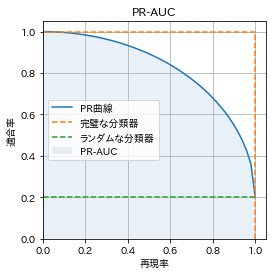

In [23]:
from helpers.imbalanced_data import pr_auc
pr_auc.show()

###### 練習問題

`mammography`データセットに任意の分類アルゴリズムを適用し、PR 曲線を表示する。

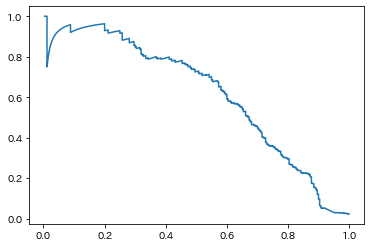

In [24]:
x = mammography.iloc[:, :-1]
y = mammography.iloc[:, -1]
proba = LogisticRegression(random_state=1234).fit(x, y).predict_proba(x)[:, 1]
df = pd.DataFrame(dict(thresh=np.sort(proba)[::-1]))
df['tp'] = df['thresh'].apply(lambda t: ((y == 1) & (proba >= t)).sum())
df['fp'] = df['thresh'].apply(lambda t: ((y == 0) & (proba >= t)).sum())
df['fn'] = df['thresh'].apply(lambda t: ((y == 1) & (proba < t)).sum())
df['pre'] = df['tp'] / (df['tp']+df['fp'])
df['rec'] = df['tp'] / (df['tp']+df['fn'])
plt.plot('rec', 'pre', data=df)
plt.show()

##### PythonでのPR曲線表示方法
---
`sklearn.metrics.plot_precision_recall_curve`を使用する。

In [25]:
metrics.plot_precision_recall_curve??

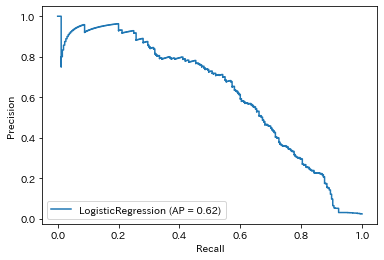

In [26]:
metrics.plot_precision_recall_curve(model, x, y)
plt.show()

##### PythonでのPR-AUC算出方法
---
`sklearn.metrics.auc`または`sklearn.metrics.average_precision_score`を使用する。  
`sklearn.metrics.auc`は点と点の間を線でつなぎ、台形の面積を算出し、`sklearn.metrics.average_precision_score`は補間せずに長方形の面積を算出する。

$P_{n},R_{n}$ をそれぞれ $n$ 番目の閾値 (降順) における適合率・再現率とすると

$\displaystyle AUC=\sum ^{n}_{i=2}( R_{n} -R_{n-1})\frac{P_{n} +P_{n-1}}{2}$

$\displaystyle AP=\sum ^{n}_{i=2}( R_{n} -R_{n-1}) P_{n}$

値の大きさは $AUC>AP$ となる。

In [27]:
metrics.auc??

In [28]:
pre, rec, _ = metrics.precision_recall_curve(pred['正解'], pred['確率'])
metrics.auc(rec, pre)

0.6182456084119635

In [29]:
metrics.average_precision_score??

In [30]:
metrics.average_precision_score(pred['正解'], pred['確率'])

0.6189431679987698

## 混同行列に基づくその他の指標
---
不均衡データに限られないが、混同行列に基づいた分類モデル評価指標を紹介する。

### 受信者操作特性(ROC, Reciever Operator Characteristic)
---
真陽性率と偽陽性率に基づく指標。

#### 真陽性率 (true positive rate)
---
関心があるクラスの中での正解率。 (再現率と同じ)

<span class="text-shadow" style="color: hotpink;">TPR</span> = <span class="text-shadow" style="color: yellow;">True Positive</span> ÷ <span class="text-shadow" style="color: purple;">Labeled True</span>

<table class="border text-center background-white text-black">
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold"><span style="color: purple;">正解ラベルが True<br>(関心のあるクラス)</span></th>
        <td style="background-color: purple;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
        <td style="background-color: purple;">偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td>偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
    </tr>
</table>

#### 偽陽性率 (false positive rate)
---
関心がないクラスの中での不正解率。 (関心ありと誤判定した割合)

<span class="text-shadow" style="color: darkgreen;">FPR</span> = <span class="text-shadow" style="color: pink;">False Positive</span> ÷ <span class="text-shadow" style="color: brown;">Labeled False</span>

<table class="border text-center background-white text-black">
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが True<br />(関心のあるクラス)</th>
        <td>真陽性<br />True Positive</td>
        <td>偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold"><span style="color: brown;">正解ラベルが False<br />(関心のないクラス)</span></th>
        <td style="background-color: brown;"><span style="color: pink;">偽陽性<br />False Positive</span></td>
        <td style="background-color: brown;">真陰性<br />True Negative</td>
    </tr>
</table>

#### 受信者操作特性 (ROC)
---
PR 曲線と同様に閾値を様々な値に変化させた場合の<span class="text-shadow" style="color: hotpink;">真陽性率</span>・<span class="text-shadow" style="color: darkgreen;">偽陽性率</span>の変化をプロットしたものが ROC 曲線。

<table class="border text-center text-black background-white">
    <tr class="border-none">
        <th  colspan="3"><span style="color: hotpink;">真陽性率<br />True Positive Rate</span></th>
        <th>
        <th colspan="3"><span style="color: darkgreen;">偽陽性率<br />False Positive Rate</span></th>
    </tr>
    <tr>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
        <th class="border-none
                   "></th>
        <th class="border-top-none border-left-none border-right-bold"></th>
        <th>True と予測</th>
        <th>False と予測</th>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold"><span style="color: purple;">正解ラベルが True<br />(関心のあるクラス)</span></th>
        <td style="background-color: purple;"><span style="color: yellow;">真陽性<br />True Positive</span></td>
            <td style="background-color: purple;">偽陰性<br />False Negative</td>
        <td class="border-none"></td>
        <th class="border-bottom border-right-bold">正解ラベルが True<br />(関心のあるクラス)</th>
        <td>真陽性<br />True Positive</td>
        <td>偽陰性<br />False Negative</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold">正解ラベルが False<br />(関心のないクラス)</th>
        <td>偽陽性<br />False Positive</td>
        <td>真陰性<br />True Negative</td>
        <td class="border-none"></td>
        <th class="border-bottom border-right-bold"><span style="color: brown;">正解ラベルが False<br />(関心のないクラス)</span></th>
        <td style="background-color: brown;"><span style="color: pink;">偽陽性<br />False Positive</span></td>
        <td style="background-color: brown;">真陰性<br />True Negative</td>
    </tr>
</table>

In [31]:
from helpers.imbalanced_data import roc_curve
roc_curve.show()

interactive(children=(SelectionSlider(continuous_update=False, description='精度', options=OrderedDict([('ランダム',…

- 閾値を上げる (確率の高いものだけ True と判定する = <span class="text-shadow" style="color: red;">True と予測</span>するものが減る) と
 - ROC 曲線の左下へ移動 (<span class="text-shadow" style="color: hotpink;">真陽性率</span>も<span class="text-shadow" style="color: darkgreen;">偽陽性率</span>も下がる)
- 閾値を下げる (確率の低いものでも True と判定する = <span class="text-shadow" style="color: red;">True と予測</span>するものが増える) と
 - ROC 曲線の右上へ移動 (<span class="text-shadow" style="color: hotpink;">真陽性率</span>も<span class="text-shadow" style="color: darkgreen;">偽陽性率</span>も上がる)
- どんなに閾値を変化させても左上の点 (<span class="text-shadow" style="color: hotpink;">真陽性率</span> $1.0$ ・<span class="text-shadow" style="color: darkgreen;">偽陽性率</span> $0.0$ から動かない分類器は全てのサンプルに対して $100\%$ の確信を持って正解の方に分類している完璧な分類器)
- 各サンプルに対してランダムに分類 (あらゆる閾値に一様にサンプルを割当て) すると対角線になる
- ROC 曲線の下部面積 (AUC, Area Under the Curve) が分類器の性能を表すと考えられる
 - 正しく分類できているかだけでなく、確信を持って分類できているかまで評価

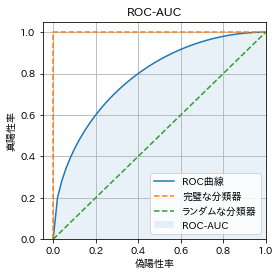

In [32]:
from helpers.imbalanced_data import roc_auc
roc_auc.show()

###### 練習問題

`mammography`データセットに任意の分類アルゴリズムを適用し、ROC 曲線を表示する。

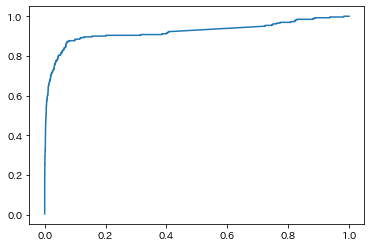

In [33]:
x = mammography.iloc[:, :-1]
y = mammography.iloc[:, -1]
proba = LogisticRegression(random_state=1234).fit(x, y).predict_proba(x)[:, 1]
df = pd.DataFrame(dict(thresh=np.sort(proba)[::-1]))
df['tp'] = df['thresh'].apply(lambda t: ((y == 1) & (proba >= t)).sum())
df['fp'] = df['thresh'].apply(lambda t: ((y == 0) & (proba >= t)).sum())
df['fn'] = df['thresh'].apply(lambda t: ((y == 1) & (proba < t)).sum())
df['tn'] = df['thresh'].apply(lambda t: ((y == 0) & (proba < t)).sum())
df['fpr'] = df['fp'] / (df['tn'] + df['fp'])
df['tpr'] = df['tp'] / (df['tp'] + df['fn'])
plt.plot('fpr', 'tpr', data=df)
plt.show()

##### PythonでのROC曲線表示方法
---
`sklearn.metrics.plot_roc_curve`を使用する。

In [34]:
metrics.plot_roc_curve??

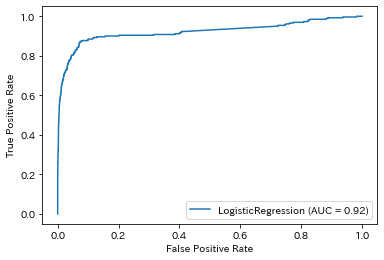

In [35]:
metrics.plot_roc_curve(model, x, y)
plt.show()

##### PythonでのROC-AUC算出方法
---
`sklearn.metrics.roc_auc_score`を使用する。

In [36]:
metrics.roc_auc_score(pred['正解'], pred['予測'])

0.7006871527264276

#### ROC-AUCとPR-AUCの比較
---
ROC-AUC も PR-AUC も分類モデルの能力を表す指標だが、一般的には ROC-AUC 、不均衡データには PR-AUC が適している。  
ROC-AUC ではランダムなモデルの能力は 0.5 に固定され、異なるデータセット間でも値によって評価しやすいが、 PR-AUC におけるランダムなモデルの能力はデータの不均衡さに左右され、異なるデータセット間での値の比較はしにくい。  
一方、不均衡データでは混同行列の真陰性 (TN) 付近の密度が高くなりやすく、 ROC 曲線では横軸の移動の大半が負例 (正解ラベルが False のサンプル) の分類変更によってもたらされ、 AUC の面積の大半を占めるが、 PR 曲線では TN の密度が高い区間付近では横軸の移動が抑えられ、 AUC の面積に占める割合も低くなる。

<table class="border">
    <tr class="text-center">
        <th></th>
        <th style="min-width: 6.5em;">横軸</th>
        <th style="min-width: 6.5em;">縦軸</th>
    </tr>
    <tr>
        <th class="text-center border-bottom">ROC-AUC</th>
        <td class="text-left">$\displaystyle \frac{FP}{FP+TN}$</td>
        <td class="text-left">$\displaystyle \frac{TP}{TP+FN}$</td>
    </tr>
    <tr>
        <th class="text-center border-bottom">PR-AUC</th>
        <td class="text-left">$\displaystyle \frac{TP}{TP+FN}$</td>
        <td class="text-left">$\displaystyle \frac{TP}{TP+FP}$</td>
    </tr>
</table>

In [37]:
from helpers.imbalanced_data import compare_auc
compare_auc.show()

Play(value=1, max=99, min=1)

Output()

## 不均衡データでの学習
---
簡単なものとして以下の方法がある。

- F1 スコアが最も高くなる閾値や PR-AUC が高くなるハイパーパラメーターを採用する
- 各クラスを平等に扱うように少ないデータに対して過学習させる ( scikit-learn の場合、 class_weight 引数を 'balanced' に設定)

[imbalanced-learn](https://imbalanced-learn.readthedocs.io/en/stable/index.html) (不均衡データ学習用のライブラリ) も参考に。

## 多クラス分類の評価

### マクロ平均法とマイクロ平均法
---
多クラス分類のための指標。

一対他で $k$ 個のクラスそれぞれの混同行列を作成したとして

マクロ平均法は、各クラスで指標を求めてから、それらの平均を最終的な指標として使用する。各クラスを平等に扱う。

$
{\displaystyle
    PRE_{macro} =\frac
        {PRE_{1} +PRE_{2} +\dotsc +PRE_{k}}
        {k}
}
$

マイクロ平均法は、それぞれの分母・分子同士を合計してから、最終的な指標の分母・分子として使用する。各サンプルを平等に扱う。

$
{\displaystyle
    PRE_{micro} =\frac
        {TP_{1} +TP_{2} +\dotsc +TP_{k}}
        {TP_{1} +TP_{2} +\dotsc +TP_{k} +FP_{1} +FP_{2} +\dotsc +FP_{k}}
}
$

scikit-learn で二値分類の指標を使って多クラス分類モデルを評価すると、デフォルトではマクロ平均を正規化 (重みづけ) したものが使用される。それ以外の平均化方法を使用したい場合は average 引数で指定。

### 多クラス分類の混同行列
---
多クラス分類でデータが不均衡かどうかは最少のクラスのサンプルサイズ:最多のクラスのサンプルサイズで考えていくことが多い。

以下のような混同行列を作成したとして、学習時には横方向の再現率・評価時には縦方向の適合率を見ることもある。

<table class="border text-black background-white">
    <tr>
        <th class="border-none text-center" colspan="5">混同行列</th>
    </tr>
    <tr class="text-center">
        <td class="border-top-none border-left-none border-bottom-bold border-right-bold" rowspan="2" colspan="2"></td>
        <th class="border-bottom" colspan="3">予測</th>
    </tr>
    <tr class="text-center">
        <th>A</th>
        <th>B</th>
        <th>C</th>
    </tr>
    <tr>
        <th class="border-bottom text-center" rowspan="3">正解ラベル</th>
        <th class="border-bottom border-right-bold text-center">A</th>
        <td class="text-right">10</td>
        <td class="text-right">15</td>
        <td class="text-right">25</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-center">B</th>
        <td class="text-right">7</td>
        <td class="text-right">40</td>
        <td class="text-right">3</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-center">C</th>
        <td class="text-right">2</td>
        <td class="text-right">3</td>
        <td class="text-right">45</td>
    </tr>
</table>

行単位で正規化して、精度の悪いクラスを捉える特徴の追加を考える。 (下の例ではAとそれ以外で顕著に変わるような特徴)

<table class="border text-black background-white">
    <tr class="text-center">
        <td class="border-top-none border-left-none border-bottom-bold border-right-bold" rowspan="2" colspan="2"></td>
        <th class="border-bottom" colspan="3">予測</th>
    </tr>
    <tr class="text-center">
        <th>A</th>
        <th>B</th>
        <th>C</th>
    </tr>
    <tr>
        <th class="border-bottom text-center" rowspan="3">正解ラベル</th>
        <th class="border-bottom border-right-bold text-center">A</th>
        <td class="text-left text-red">0.2</td>
        <td class="text-left">0.3</td>
        <td class="text-left">0.5</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-center">B</th>
        <td class="text-left">0.14</td>
        <td class="text-left text-red">0.8</td>
        <td class="text-left">0.06</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-center">C</th>
        <td class="text-left">0.04</td>
        <td class="text-left">0.06</td>
        <td class="text-left text-red">0.9</td>
    </tr>
</table>

列単位で正規化して、それぞれの予測の信頼性を確認する。 (運用した際の体感的なクラス別精度)

<table class="border text-black background-white">
    <tr class="text-center">
        <td class="border-top-none border-left-none border-bottom-bold border-right-bold" rowspan="2" colspan="2"></td>
        <th class="border-bottom" colspan="3">予測</th>
    </tr>
    <tr class="text-center">
        <th>A</th>
        <th>B</th>
        <th>C</th>
    </tr>
    <tr>
        <th class="border-bottom text-center" rowspan="3">正解ラベル</th>
        <th class="border-bottom border-right-bold text-center">A</th>
        <td class="text-left text-red">0.53</td>
        <td class="text-left">0.26</td>
        <td class="text-left">0.34</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-center">B</th>
        <td class="text-left">0.37</td>
        <td class="text-left text-red">0.69</td>
        <td class="text-left">0.04</td>
    </tr>
    <tr>
        <th class="border-bottom border-right-bold text-center">C</th>
        <td class="text-left">0.11</td>
        <td class="text-left">0.05</td>
        <td class="text-left text-red">0.62</td>
    </tr>
</table>